# Projet TAL - Discours de François Miterrand ou Jacques Chirac - GUIMONT Mathieu 
On dispose d'un fichier contenant des bouts de discours et des labels associés à ces bouts de discours (qui correspondent aux présidents qui les ont prononcés, Chirac ou Mitterrand).
Le but de ce projet est de prédire si un bout de discours a été prononcé par Miterrand ou Chirac.

In [2]:
import gensim
import logging

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn import datasets
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn import linear_model, naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import optuna

from IPython.display import display, HTML


C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import des données

In [3]:
with open('corpus.tache1.learn.utf8', 'r', encoding='utf-8') as fichier1:
    train = fichier1.read()

In [4]:
#Fonctions utiles
#Validation Croisée et affiche les résultats de la validation croisée
def make_cv_analysis_classifier(classifier, X, y):
    cv = ShuffleSplit(n_splits=10, test_size=0.2)
    result_cv = cross_val_score(
        classifier, X, y, cv=cv,
        scoring="accuracy",
        n_jobs=-1)
    
    sns.displot(result_cv, kde=True, bins=20)
    plt.xlabel('Accuracy')
    print('Scores de précision de la validation croisée: ', result_cv)
    print('Moyenne des scores: ', result_cv.mean())
    return result_cv.mean()

#Evaluation du classifier avec balanced_accuracy_score, affichage du balanced_accuracy_score ainsi que du score classique
def evaluate_classifier(clf):
    name = getattr(clf, 'name', clf.__class__.__name__)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    display(HTML(
        f"<h5>{name}</h5>"
        f"Test Accuracy: {score:7.2%} <br/>"
        f"Balanced accuracy: {balanced_score:7.2%} <br/>"
    ))
    return balanced_score

# Prétraitements

In [5]:
#Découpage des lignes
Corpus=train.splitlines()

#Définition de X_train
X = [line.split('>', 1)[1].strip() for line in Corpus]

#Définition de y_train
y=[]
for doc in Corpus:
    for character in doc:
        if character=="C":
            y.append(character)
            break
        elif character=="M":
            y.append(character)
            break

Ratio C/M:  6.631662900438655


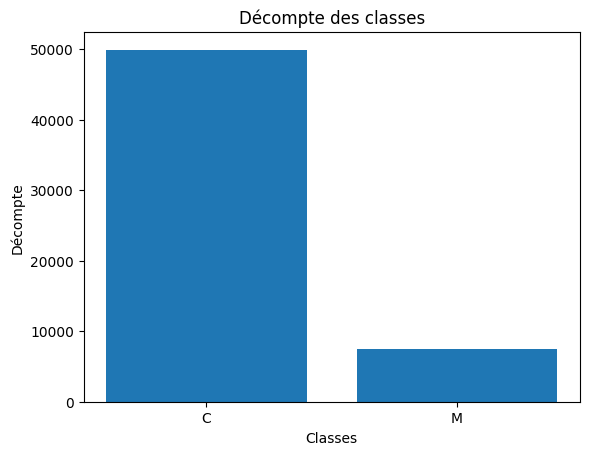

In [6]:
#Histogramme
counts = {'C': y.count('C'), 'M': y.count('M')}
print('Ratio C/M: ', y.count('C')/y.count('M'))

# Créer un histogramme à partir du décompte
plt.bar(counts.keys(), counts.values())
plt.xlabel('Classes')
plt.ylabel('Décompte')
plt.title('Décompte des classes')
plt.show()

Nos classes sont fortement déséquilibrés.
On vérifie si on a ce même déséquilibre dans nos données de test et d'entraînement.

Ratio C/M:  6.631662900438655


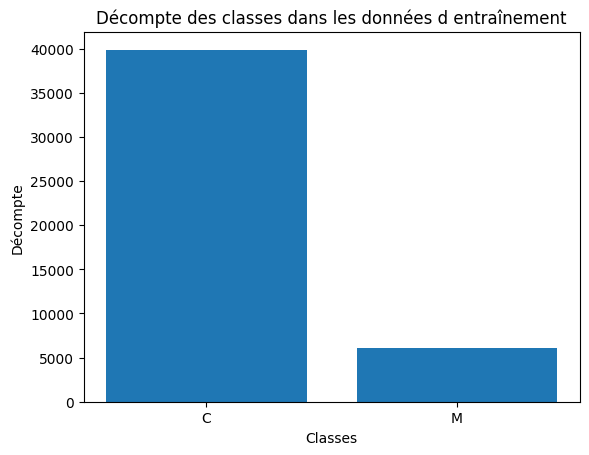

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

counts = {'C': y_train.count('C'), 'M': y_train.count('M')}
print('Ratio C/M: ', y.count('C')/y.count('M'))

# Créer un histogramme à partir du décompte
plt.bar(counts.keys(), counts.values())
plt.xlabel('Classes')
plt.ylabel('Décompte')
plt.title("Décompte des classes dans les données d entraînement")
plt.show()

In [10]:
print(y_test,y_train)

['C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'M', 'C', 'C', 'C', 'M', 'M', 'C', 'C', 'C', 'M', 'C', 'M', 'C', 'C', 'C', 'C', 'M', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'M', 'M', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'M', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',

Ratio C/M:  6.631662900438655


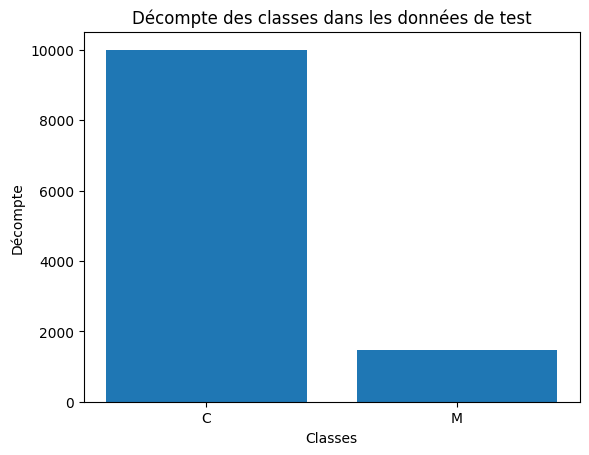

In [14]:
counts = {'C': y_test.count('C'), 'M': y_test.count('M')}
print('Ratio C/M: ', y.count('C')/y.count('M'))

# Créer un histogramme à partir du décompte
plt.bar(counts.keys(), counts.values())
plt.xlabel('Classes')
plt.ylabel('Décompte')
plt.title('Décompte des classes dans les données de test')
plt.show()

Nos classes sont donc également déséquilibrées.

On va maintenant définir le modèle Word2Vec afin de vectoriser les mots de nos données. 
Word2Vec représente chaque mot sous forme d'un vecteur dense dans un espace continu, où des mots similaires sont proches les uns des autres. Ces représentations vectorielles capturent les relations sémantiques et syntaxiques entre les mots. Les vecteurs ont également une dimension relativement faible par rapport à la taille du vocabulaire

In [8]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# configuration par défaut
w2v = gensim.models.word2vec.Word2Vec(sentences=X,
                                vector_size=100, window=5,               
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,       
                                cbow_mean=1, epochs=5)

# Récupérer les vecteurs de mots à partir du modèle Word2Vec
word_vectors = w2v.wv

# Créer une liste des vecteurs de mots pour les mots présents dans chaque document de X_train
X_w2v = []
for doc in X:
    # Obtenir les vecteurs pour chaque mot dans le document et les moyenne
    vectors = [word_vectors[word] for word in doc if word in word_vectors]
    if vectors:
        doc_vector = np.mean(vectors, axis=0)
    else:
        doc_vector = np.zeros(w2v.vector_size)  # Vecteur nul si aucun mot présent dans le vocabulaire du modèle
    X_w2v.append(doc_vector)

#On sépare maintenant notre jeu de données en données de test et d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

print('len(X_train): ', len(X_train))
print('len(X_test): ', len(X_test))

print('len(y_train): ', len(y_train))
print('len(y_test): ', len(y_test))
    

2024-01-20 12:29:52,896 : INFO : collecting all words and their counts
2024-01-20 12:29:52,899 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2024-01-20 12:29:52,900 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-01-20 12:29:53,220 : INFO : PROGRESS: at sentence #10000, processed 1364638 words, keeping 98 word types
2024-01-20 12:29:53,743 : INFO : PROGRESS: at sentence #20000, processed 2731628 words, keeping 106 word types
2024-01-20 12:29:53,968 : INFO : PROGRESS: at sentence #30000, processed 4047400 words, keeping 106 word types
2024-01-20 12:29:54,316 : INFO : PROGRESS: at sentence #40000, processed 5350445 words, keeping 107 word types
2024-01-20 12:29:54,534 : INFO : PROGRESS: at sentence #50000, processed 6723496 words, keeping 109 word types
2024-01-20 12:29:54,706 : INFO : collected 110 word types from a corpus of 7717837 raw words and 57413 sentences
2024

len(X_train):  45930
len(X_test):  11483
len(y_train):  45930
len(y_test):  11483


In [24]:
#On sauvegard les embeddings
w2v.save("W2v-movies.dat")

2024-01-03 18:13:02,352 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'W2v-movies.dat', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-01-03T18:13:02.352440', 'gensim': '4.3.2', 'python': '3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'saving'}
2024-01-03 18:13:02,354 : INFO : not storing attribute cum_table
2024-01-03 18:13:02,359 : INFO : saved W2v-movies.dat


# Tests de modèles de classification sur les données
On va tester trois modèles: naive_bayes, SVC et RandomForestClassifier car ils correspondent à nos données.
On va également tester BalancedRandomForestClassifier qui sera probablement plus adapté à nos données déséquilibrées.

Pour chacun de ces modles, on optimisera les hyperparamètres avec la bibliothèque optuna.
On calculera les métriques accuracy_score roc_auc_score afin d'évaluer nos modèles et d'afficher des diagrammes en barres à la fin du notebook. 
On réalisera également des validations croisées et on calculera la métrique balanced_accuracy_score, qui sera peut être plus adaptée à nos données déséquilibrées.

# Dummy Classifier

Ce modèle est très simple. Il n'apprend rien des données et se contente de renvoyer la classe la plus fréquente.
Ce modèle servira à comparer les performances des autres modèles.

Scores de précision de la validation croisée:  [0.86963337 0.86832709 0.86562745 0.87024297 0.87764521 0.8741618
 0.86554036 0.87372638 0.86998171 0.87128799]
Moyenne des scores:  0.8706174344683445


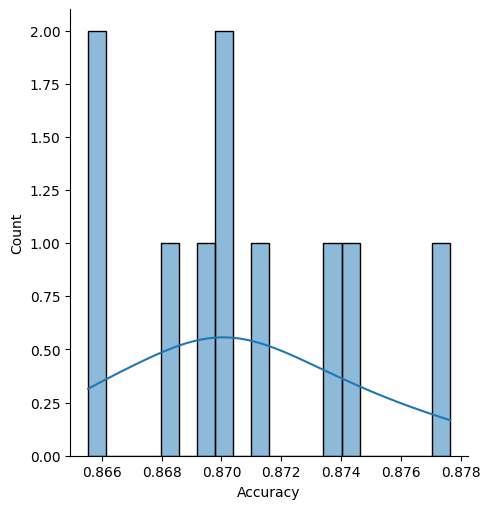

In [17]:
# Création du modèle DummyClassifier
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
# Entraînement du modèle
dummy_model.fit(X_train, y_train)
# Prédictions sur l'ensemble de test
y_pred = dummy_model.predict(X_test)

#Calcul des métriques
y_prob_dummy=dummy_model.predict_proba(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred)
roc_auc_dummy = roc_auc_score(y_test, y_prob_dummy[:,1])
balanced_accuracy_dummy= evaluate_classifier(dummy_model)
cross_val_score_dummy=make_cv_analysis_classifier(dummy_model, X_w2v, np.array(y))

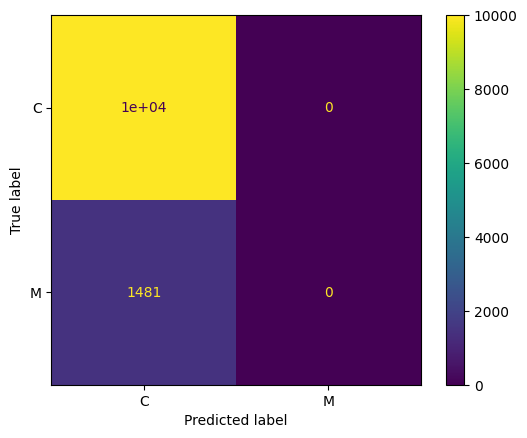

In [67]:
#Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# Naive Bayes
Naive Bayes est basé sur le théorème de Bayes avec une forte hypothèse d'indépendance conditionnelle entre les caractéristiques. Il est "naïf" car il suppose une indépendance simple entre chaque paire de caractéristiques, ce qui est une simplification peu réaliste.

In [74]:
model_NB = naive_bayes.GaussianNB()
model_NB.fit(X_train,y_train)
y_pred=model_NB.predict(X_test)

accuracy_NB= accuracy_score(y_test, y_pred)
conf_matrix_NB = confusion_matrix(y_test, y_pred)
y_prob_NB = model_NB.predict_proba(X_test)
roc_auc_NB = roc_auc_score(y_test, y_prob_NB[:,1])

Scores de précision de la validation croisée:  [0.26952887 0.2634329  0.27301228 0.27179309 0.26839676 0.27144474
 0.26987721 0.25803361 0.26203954 0.28137246]
Moyenne des scores:  0.2688931463903161


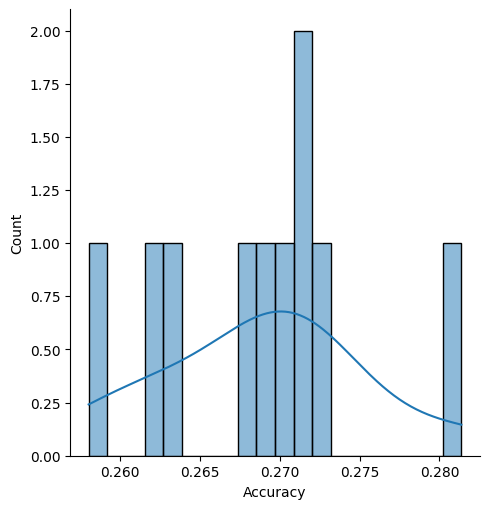

In [70]:
balanced_accuracy_NB= evaluate_classifier(model_NB)
cross_val_score_NB=make_cv_analysis_classifier(model_NB, X_w2v, np.array(y))

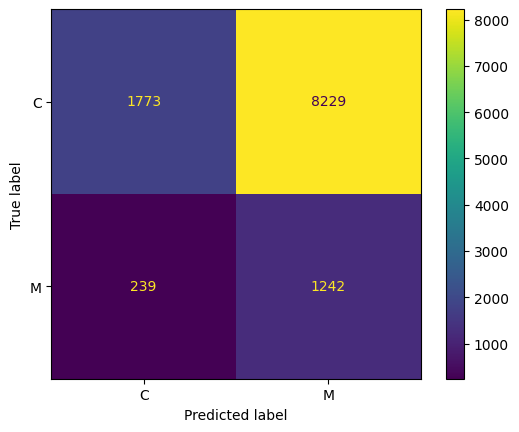

In [69]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# SVM
Le modèle SVM.SVC est un classificateur de machine learning basé sur les machines à vecteurs de support. Son principe est de trouver un hyperplan optimal qui sépare les différentes classes dans l'espace des caractéristiques. Il cherche à maximiser la marge entre les classes tout en minimisant le risque de classification erronée.


In [29]:
# Optimisation du modèle SVM
def objective(trial):
    # Paramètres à optimiser : C, gamma, kernel
    C = trial.suggest_float('C', 0.1, 10.0)  # Valeurs de C à tester entre 0.1 et 10.0
    gamma = trial.suggest_float('gamma', 0.1, 1.0)  # Valeurs de gamma à tester entre 0.1 et 1.0
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])  # Type de noyau à tester

    # Création du modèle SVM avec les hyperparamètres suggérés
    model = SVC(C=C, gamma=gamma, kernel=kernel)
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test et calcul de la précision
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Création de l'étude Optuna et exécution de l'optimisation
study = optuna.create_study(direction='maximize')  # 'maximize' pour maximiser la précision
study.optimize(objective, n_trials=100)  # Nombre de tentatives à essayer

# Affichage des résultats de l'optimisation
print('Best trial:')
trial = study.best_trial
print(f'  Accuracy: {trial.value:.4f}')
print(f'  Params: {trial.params}')

[I 2024-01-04 14:43:46,601] A new study created in memory with name: no-name-7ac6437d-8237-43f1-a604-c9732fef32b2
[I 2024-01-04 14:46:53,884] Trial 0 finished with value: 0.8710267351737351 and parameters: {'C': 7.2049220610519225, 'gamma': 0.16309404083915913, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8710267351737351.
[I 2024-01-04 14:51:40,023] Trial 1 finished with value: 0.8710267351737351 and parameters: {'C': 5.85856381503943, 'gamma': 0.8697661185532015, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8710267351737351.
[I 2024-01-04 14:53:23,686] Trial 2 finished with value: 0.8710267351737351 and parameters: {'C': 4.686576196167719, 'gamma': 0.6947911222524769, 'kernel': 'linear'}. Best is trial 0 with value: 0.8710267351737351.
[I 2024-01-04 14:54:45,515] Trial 3 finished with value: 0.8710267351737351 and parameters: {'C': 0.41810848870091766, 'gamma': 0.9862384829823541, 'kernel': 'poly'}. Best is trial 0 with value: 0.8710267351737351.
[I 2024-01-04 14:56:35,380] Tri

Best trial:
  Accuracy: 0.8710
  Params: {'C': 7.2049220610519225, 'gamma': 0.16309404083915913, 'kernel': 'rbf'}


Après 260 minutes de calcul:
Best trial:
  Accuracy: 0.8710
  Params: {'C': 7.2049220610519225, 'gamma': 0.16309404083915913, 'kernel': 'rbf'}

Maintenant calculons les métriques associées aux modèle optimisé

In [80]:
#Entraînement d'un modèle SVM et prédiction:
model_SVM=svm.SVC(C=7.2049220610519225, gamma=0.16309404083915913, kernel='rbf', probability=True)
model_SVM.fit(X_train,y_train)
y_pred=model_SVM.predict(X_test)

In [81]:
#Récupération des métriques
accuracy_SVM= accuracy_score(y_test, y_pred)
y_prob_SVM = model_SVM.predict_proba(X_test)
roc_auc_SVM = roc_auc_score(y_test, y_prob_SVM[:,1])

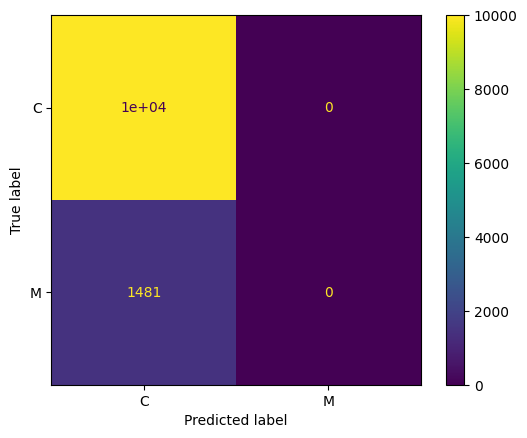

In [82]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

SVM n'a classé aucun élément de X_test dans la classe Miterrand. Sa performance est donc similaire à celle d'un DummyClassifier. Le modèle svm.SVC est donc très sensible à la classe majoritaire auquel il donne un poids plus fort.

In [84]:
#Unbalanced_accuracy_score
balanced_accuracy_SVM= evaluate_classifier(model_SVM)

Scores de précision de la validation croisée:  [0.87067839 0.86919794 0.86806584 0.87355221 0.8688496  0.86972046
 0.87128799 0.86754332 0.86501785 0.86815292]
Moyenne des scores:  0.8692066533135939


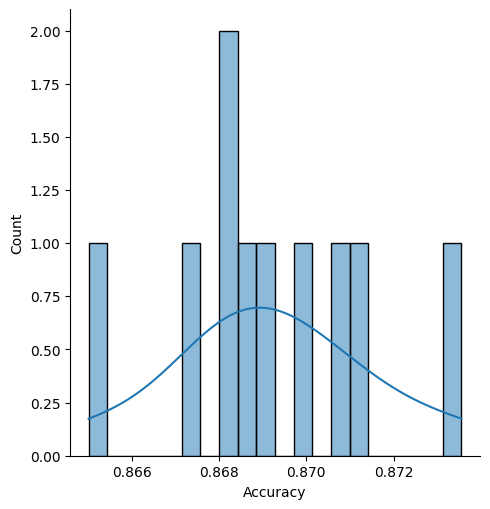

In [83]:
#Cross-validation et unbalanced_accuracy_score
cross_val_score_SVM=make_cv_analysis_classifier(model_SVM, X_w2v, np.array(y))

# RandomForestClassifier

Les forêts aléatoires, étant construites à partir d'arbres de décision, et elles peuvent gérer naturellement les déséquilibres de classe. Elle sont capables de modéliser des relations complexes et non linéaires entre les caractéristiques et la variable cible.

On s'attend donc à obtenir une meilleure performance.

In [32]:
#Optimisation de RandomForestClassifier
def objective(trial):
    # Paramètres à optimiser pour RandomForestClassifier
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [None,'sqrt', 'log2'])

    # Création du modèle RandomForestClassifier avec les hyperparamètres suggérés
    model = RandomForestClassifier( 
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test et calcul de la précision
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Création de l'étude Optuna et exécution de l'optimisation
study = optuna.create_study(direction='maximize')  # 'maximize' pour maximiser la précision
study.optimize(objective, n_trials=10)  # Nombre de tentatives à essayer

# Affichage des résultats de l'optimisation
print('Best trial:')
trial = study.best_trial
print(f'  Accuracy: {trial.value:.4f}')
print(f'  Params: {trial.params}')

[I 2024-01-05 16:43:46,568] A new study created in memory with name: no-name-33a73a8d-32bf-4187-b3ab-143107157aed


[I 2024-01-05 16:49:45,671] Trial 0 finished with value: 0.8702429678655403 and parameters: {'n_estimators': 13, 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.8702429678655403.
[I 2024-01-05 16:50:53,940] Trial 1 finished with value: 0.8710267351737351 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8710267351737351.
[I 2024-01-05 16:52:11,489] Trial 2 finished with value: 0.8710267351737351 and parameters: {'n_estimators': 75, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.8710267351737351.
[I 2024-01-05 16:54:28,467] Trial 3 finished with value: 0.8720717582513281 and parameters: {'n_estimators': 97, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 3 with value: 0.8720717582513281.


Best trial:
  Accuracy: 0.8728
  Params: {'n_estimators': 96, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': None}


Après 81 minutes de calcul:
Best trial:
  Accuracy: 0.8728
  Params: {'n_estimators': 96, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': None}

Maintenant calculons les métriques associées au modèle optimisé.

Scores de précision de la validation croisée:  [0.87076548 0.86841418 0.86850126 0.86980754 0.87102674 0.8694592
 0.86893669 0.86736915 0.86719498 0.8718105 ]
Moyenne des scores:  0.8693285726726465


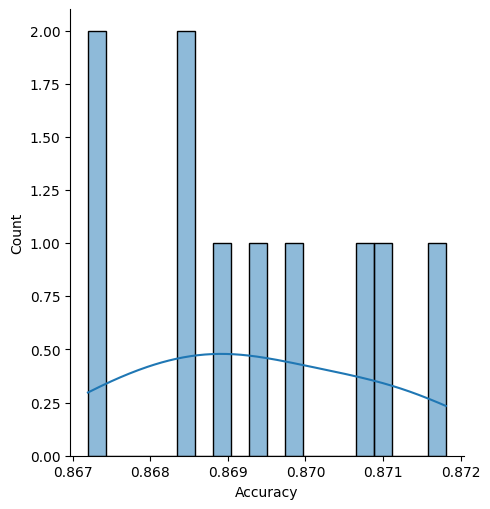

In [85]:
#Calcul des métriques pour RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=96, max_depth=15, min_samples_split=13, min_samples_leaf=6, max_features= None, random_state=42)
rf_model.fit(X_train, y_train)
y_pred=rf_model.predict(X_test)

# Prédiction des probabilités pour les données de test
y_prob = rf_model.predict_proba(X_test)

# Calcul des métriques
accuracy_rf=accuracy_score(y_test,y_pred)
confusion_matrice_rf=confusion_matrix(y_test,y_pred)
roc_auc_rf = roc_auc_score(y_test, y_prob[:, 1])  # Sélection de la colonne des probabilités pour la classe positive

balanced_accuracy_rf= evaluate_classifier(rf_model)
cross_val_score_rf=make_cv_analysis_classifier(rf_model, X_w2v, np.array(y))


In [86]:
print(accuracy_rf)
print(confusion_matrice_rf)
print(roc_auc_rf)

0.8724200992771923
[[9990   12]
 [1453   28]]
0.6860672429997458


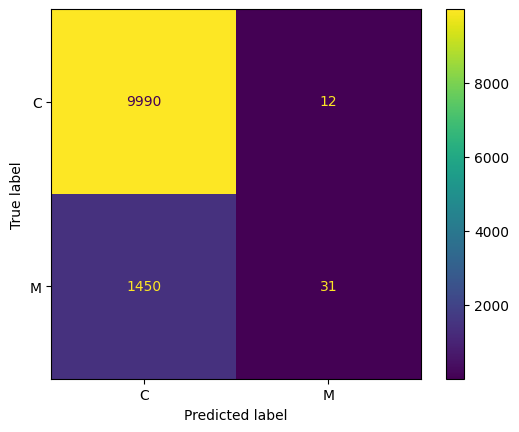

In [104]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Considérant que nos classes sont très déséquilibrés, on peut utiliser des modèles spécialement conçus pour gérer des classes déséquilibrées

# BalancedRandomForest

BalancedRandomForestClassifier a une capacité à traiter les ensembles de données déséquilibrées de manière efficace. Il intègre un mécanisme intégré de pondération des classes pour réduire l'impact des classes majoritaires, permettant ainsi de mieux modéliser les classes minoritaires.

In [29]:
# Définition de la fonction objectif pour l'optimisation
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
    }

    model = BalancedRandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Affichage des résultats
print("Meilleurs hyperparamètres:", study.best_params)
print("Meilleur score d'accuracy:", study.best_value)

# Obtention des meilleurs hyperparamètres
best_params = study.best_params

print('\n')
print("Meilleurs hyperparamètres:")
for param_name, param_value in best_params.items():
    print(f"{param_name}: {param_value}")

[I 2024-01-14 15:19:41,682] A new study created in memory with name: no-name-1025f789-cf1e-4fa1-8993-7d06e2175d83
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
[I 2024-01-14 15:19:56,266]

Meilleurs hyperparamètres: {'n_estimators': 125, 'max_depth': 9, 'min_samples_split': 0.8418122644930603, 'min_samples_leaf': 0.419138453015398}
Meilleur score d'accuracy: 0.8710267351737351


Meilleurs hyperparamètres:
n_estimators: 125
max_depth: 9
min_samples_split: 0.8418122644930603
min_samples_leaf: 0.419138453015398


In [30]:
#Calcul des métriques
brf_model = BalancedRandomForestClassifier(**best_params, random_state=42)
brf_model.fit(X_train, y_train)
y_pred=brf_model.predict(X_test)

# Prédiction des probabilités pour les données de test
y_prob_brf = brf_model.predict_proba(X_test)

# Calcul des métriques
accuracy_brf=accuracy_score(y_test,y_pred)
confusion_matrice_brf=confusion_matrix(y_test,y_pred)
roc_auc_brf = roc_auc_score(y_test, y_prob_brf[:, 1])
unbalanced_score_brf= evaluate_classifier(brf_model)

C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\valentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages

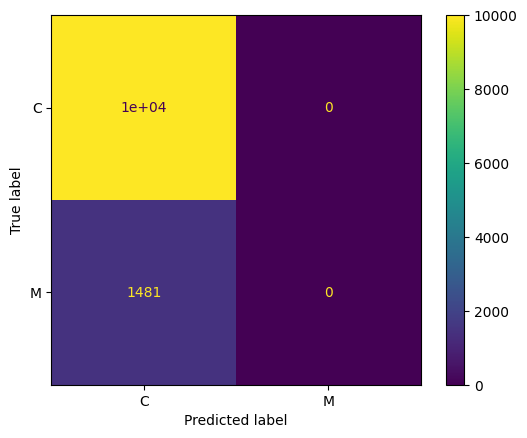

In [49]:
#Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Scores de précision de la validation croisée:  [0.87355221 0.87137508 0.87120091 0.86841418 0.87146216 0.86806584
 0.86937212 0.86597579 0.8724201  0.8688496 ]
Moyenne des scores:  0.8700687973526083


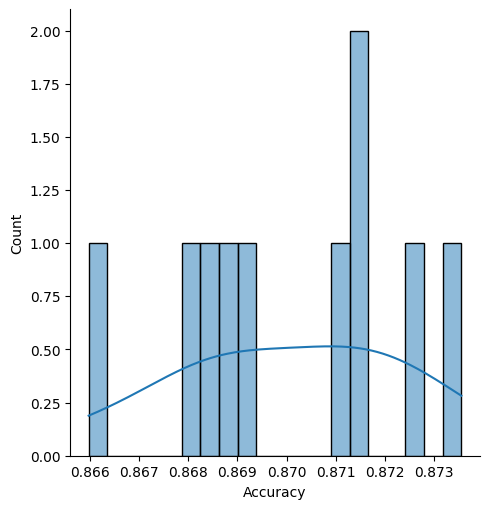

In [51]:
#Cross-validation
cross_val_score_brf= make_cv_analysis_classifier(brf_model, X_w2v, np.array(y))

# Affichage des résultats

In [ ]:
#Diagrammes bar des performances optimiséess de chaque modèle

def plot_diagramme_bar(metrique1,metrique2,metrique3,metrique4,metrique5, metric_name):
    # Exemple de données
    categories = ['Dummy Classifier','Naive Bayes', 'SVM', 'RandomForestClassifier', 'BalancedRandomForestClassifier']
    values = [metrique1,metrique2,metrique3,metrique4,metrique5]

    # Création du diagramme à barres
    plt.figure(figsize=(18, 6))  
    plt.bar(categories, values)

    # Ajout de labels et de titre
    plt.xlabel('Modèles')
    plt.ylabel(metric_name)
    plt.title('Performances maximales évaluées pour chaque modèle')

    # Affichage du diagramme
    print(values)
    plt.show()


Les codes, prennant beaucoup de temps à s'executer (Plus de 10 heures de temps d'exécution). Nous n'avons pas pu les exécuter à nouveau. Nous avons donc récupéré les valeurs des métriques grâce à des affichages (qui ont été effacés depuis).

[0.5, 0.2629974745275625, 0.8710267351737351, 0.2629974745275625, 0.5]


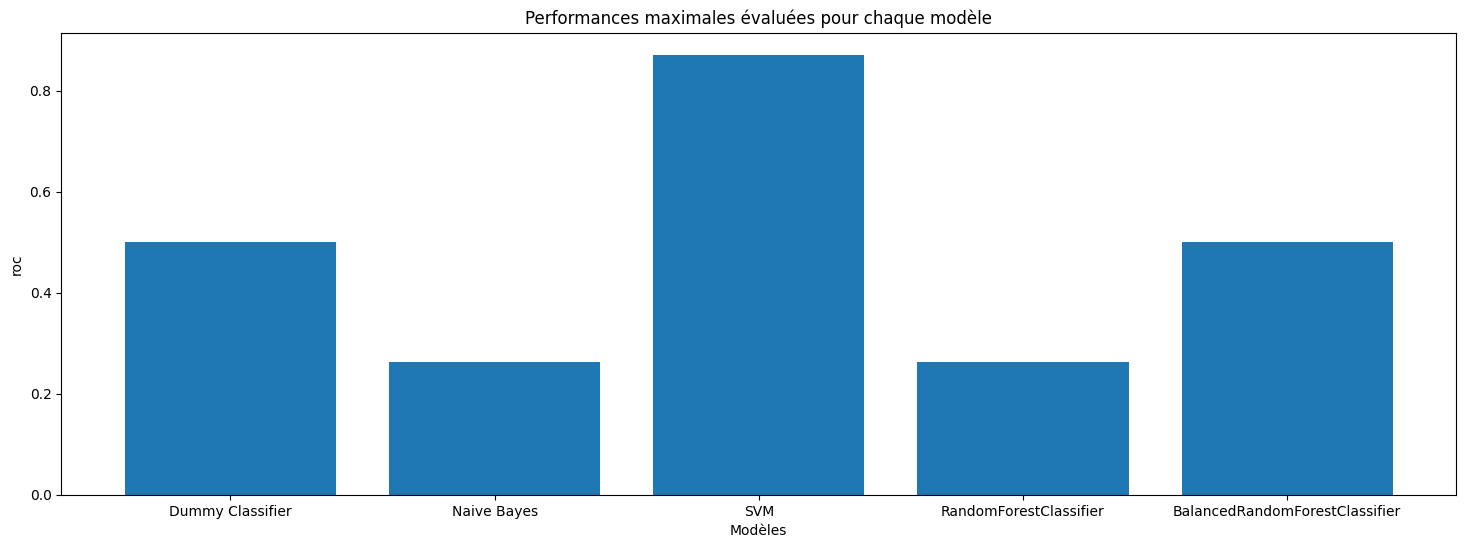

In [28]:
#On recopie les valeurs de roc_auc
plot_diagramme_bar(0.5,0.2629974745275625, 0.8710267351737351,0.2629974745275625, 0.5,'roc')

[0.8710267351737351, 0.6909842879499725, 0.614112221444975, 0.5227901077448251, 0.8710267351737351]


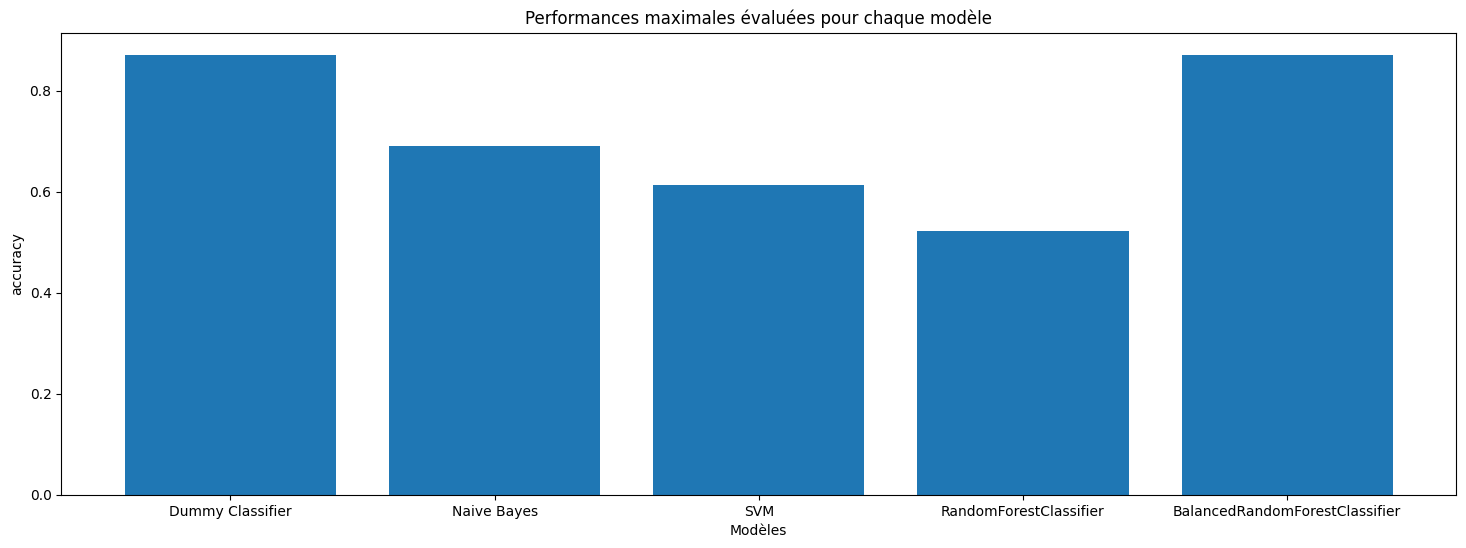

In [26]:
#Pour accuracy
plot_diagramme_bar(0.8710267351737351,0.6909842879499725, 0.614112221444975,0.5227901077448251,0.8710267351737351,'accuracy')

[0.8687102673517373, 0.2688931463903161, 0.8692066533135939, 0.8693285726726465, 0.8700687973526083]


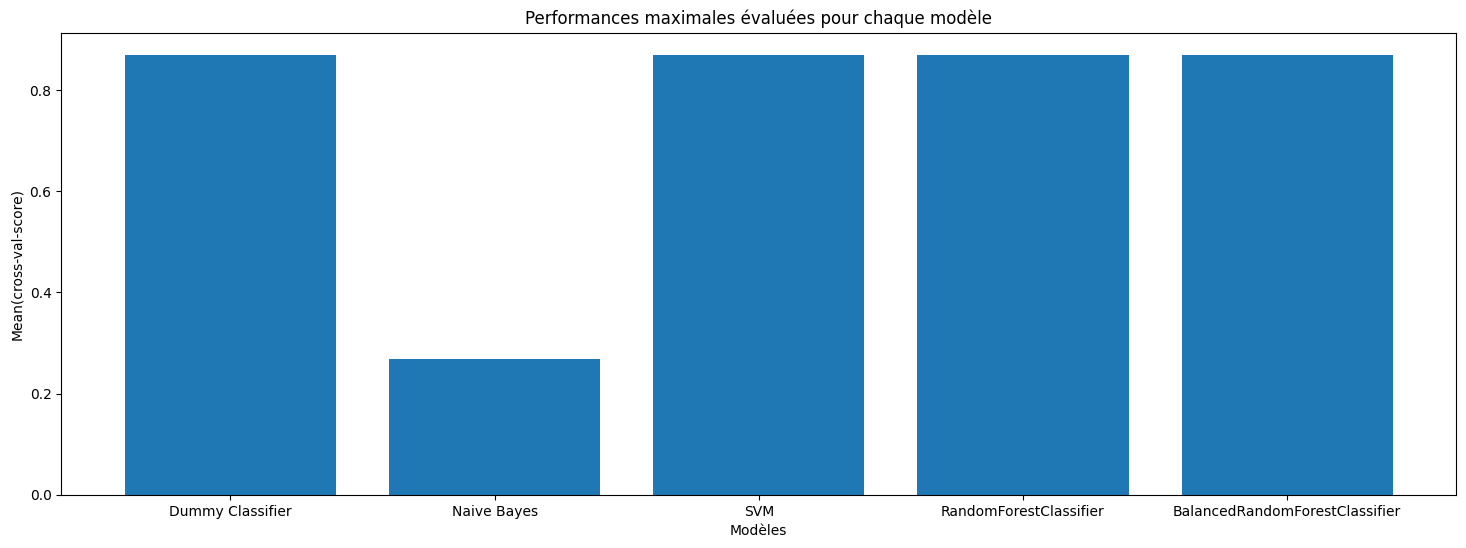

In [9]:
#Pour cross_val_scores (les codes prenant énormément de temps à compiler, il nous est impossible de les executer à nouveau)
plot_diagramme_bar( 0.8687102673517373,0.2688931463903161, 0.8692066533135939, 0.8693285726726465, 0.8700687973526083, 'Mean(cross-val-score)')

[50.0, 50.79, 50.0, 50.89, 50.0]


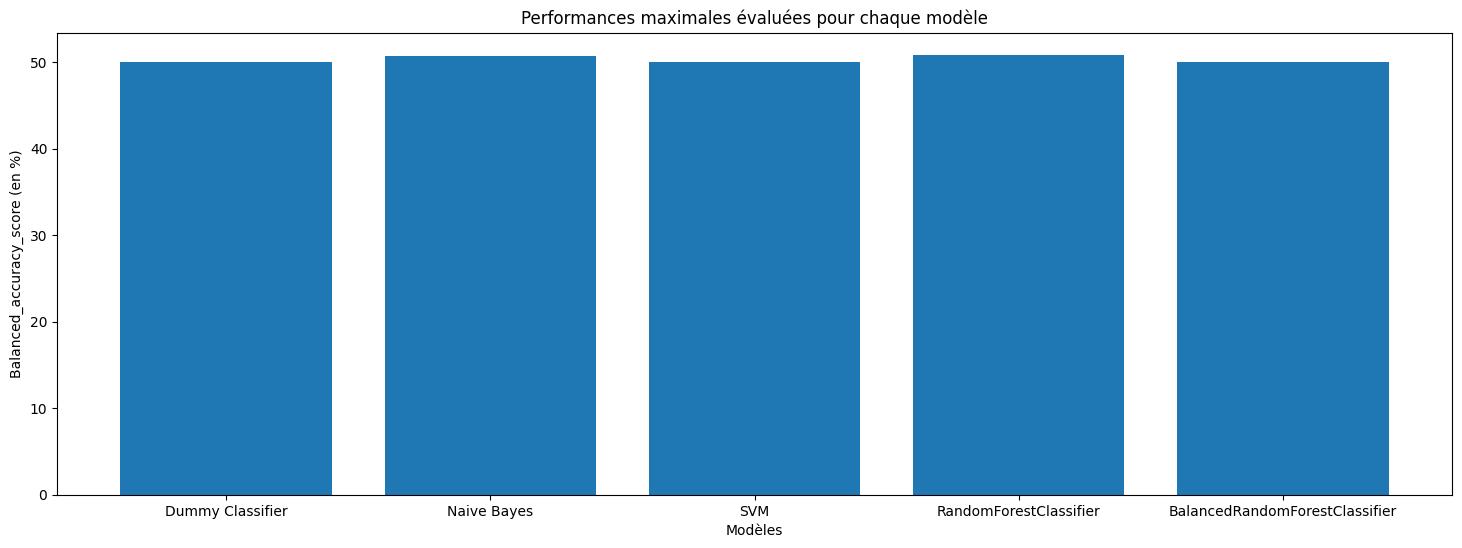

In [8]:
#Pour Balanced_accuracy_score
plot_diagramme_bar(50.00, 50.79,50.00 ,50.89,50.00 ,'Balanced_accuracy_score (en %)')

Les données étant très déséquilibrées, nos modèles ne semblent pas avoir appris les patterns liés aux discours de Miterrand.
Le modèle Dummy Classifier étant presque au maximum pour chaque métrique.